In [1]:
generate_data = False

In [1]:
import numpy as np
import run_continuum as run
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.signal
import scipy as scp
import pickle

import warnings
warnings.filterwarnings('ignore')

from frictionlaws import SlipWeakeningFrictionLaw
from predictions import *

In [3]:
# Create a small dataset with different decaying taubar
if generate_data:
    dt = 1e-2
    tmax = 5000
    gamma = 0.65
    beta = 0.001
    output_interval = 100
    N_max = 200
    dataPulse = []
    dataCrack = []
    dc = 0

    for runInd in range(1,N_max,10):
#        print(runInd)
        x = np.linspace(0,1*(runInd+1),1*(runInd+1)*10)
        tau = np.linspace(1,-.99,len(x))

        tau = np.append(tau,np.ones(len(x)*2)*-.99) # add a bit more at the end for cracks
        x = np.linspace(0,1*(runInd+1)*3,1*(runInd+1)*10*3)
        tau[0]=1
        tau[tau<-.99]=-.99

        # run
        dataPulse.append(run.run_continuum(x = x,
                                  tau = tau,
                                  tau_minus = tau+2,
                                  dt = dt,
                                  output_interval = output_interval,
                                  gamma = gamma,
                                  tmax = tmax,
                                  beta = beta,
                                  bc='fixed',
                                  frictionLaw = SlipWeakeningFrictionLaw(dc=dc,delta_u = np.zeros(np.size(x))))
                        )

        # run
        dataCrack.append(run.run_continuum(x = x,
                                  tau = tau,
                                  tau_minus = tau+2,
                                  dt = dt,
                                  output_interval = output_interval,
                                  gamma = 0,
                                  tmax = tmax,
                                  beta = beta,
                                  bc='fixed',
                                  frictionLaw = SlipWeakeningFrictionLaw(dc=dc,delta_u = np.zeros(np.size(x))))
                        )

    pickle.dump({'dataPulse': dataPulse,'dataCrack': dataCrack},  open( "data/linearly_decaying_prestress.p", "wb" ))
else:
    data = pickle.load( open( "data/linearly_decaying_prestress.p", "rb" ) )
    dataPulse = data['dataPulse']
    dataCrack = data['dataCrack']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


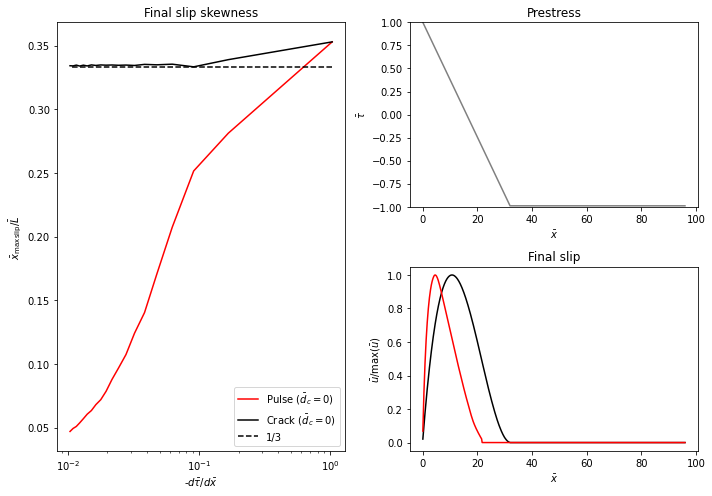

In [4]:
# Plot:
dtau_dx_pulse = []
x_L_pulse = []
dtau_dx_crack = []
x_L_crack = []

for i in range(len(dataPulse)):
    x_max = dataPulse[i]['x'][np.argmax(dataPulse[i]['u'][:,-1])]
    L = dataPulse[i]['x'][np.sum(dataPulse[i]['u'][:,-1]>0)-1]

    dtau_dx_pulse.append((1-dataPulse[i]['tau'][1])/dataPulse[i]['x'][1])
    x_L_pulse.append(x_max/L)

    x_max = dataCrack[i]['x'][np.argmax(dataCrack[i]['u'][:,-1])]
    L = dataCrack[i]['x'][np.sum(dataCrack[i]['u'][:,-1]>0)-1]
    dtau_dx_crack.append((1-dataCrack[i]['tau'][1])/dataCrack[i]['x'][1])
    x_L_crack.append(x_max/L)

fig = plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.plot(dtau_dx_pulse, x_L_pulse,'-r', label = 'Pulse ($\\bar d_c = 0$)')
plt.plot(dtau_dx_crack, x_L_crack,'-k', label = 'Crack ($\\bar d_c = 0$)')
plt.plot(dtau_dx_crack,np.zeros(len(dtau_dx_crack))*0+1/3,'--k',label = '1/3')
plt.xscale('log')
plt.xlabel('-$d\\bar \\tau / d \\bar x$')
plt.ylabel('$\\bar x_\mathrm{max slip} / \\bar L$')
plt.title('Final slip skewness')
plt.legend()

plotind = 3
plt.subplot(2,2,2)
plt.plot(dataCrack[plotind]['x'],dataCrack[plotind]['tau'],'gray')
plt.ylim([-1,1])
plt.xlabel('$\\bar x$')
plt.ylabel('$\\bar \\tau$')
plt.title('Prestress')

plt.subplot(2,2,4)
plt.plot(dataCrack[plotind]['x'],dataCrack[plotind]['u'][:,-1]/np.max(dataCrack[plotind]['u'][:,-1]),'k')
plt.plot(dataPulse[plotind]['x'],dataPulse[plotind]['u'][:,-1]/np.max(dataPulse[plotind]['u'][:,-1]),'r')
plt.xlabel('$\\bar x$')
plt.ylabel('$\\bar u / \mathrm{max}(\\bar u)$')
plt.title('Final slip')

plt.tight_layout()

plt.savefig('final_slip_skewness_linear_prestress.eps', format='eps')